In [184]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

In [162]:
password = getpass.getpass()

········


In [163]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
query = '''
WITH cte_rented as (
SELECT
      f.film_id,
	  c.category_id,
	  f.language_id,
      r.rental_date,
      f.rental_duration,
      f.rating,
      f.length,
      f.special_features
FROM sakila.inventory i
JOIN sakila.film f ON i.film_id = f.film_id
JOIN sakila.rental r ON i.inventory_id = r.inventory_id
JOIN sakila.film_category fc ON f.film_id = fc.film_id
JOIN sakila.category c ON c.category_id = fc.category_id
)
SELECT
      f.film_id,
	  f.language_id,
      r.rental_date,
      f.rental_duration,
      f.rating,
      f.length,
      f.special_features,
    CASE WHEN MONTH(r.rental_date) = 2 AND YEAR(r.rental_date) = 2006 
            THEN 'True' 
            ELSE 'False' 
			END AS rented_feb_2006 
from sakila.inventory i
join sakila.film f on i.film_id = f.film_id
join sakila.rental r on i.inventory_id = r.inventory_id;
'''

In [203]:
data = pd.read_sql_query(query, engine)

In [204]:
data

,film_id,language_id,rental_date,rental_duration,rating,length,special_features,rented_feb_2006
0,1,1,2005-07-08 19:03:15,6,PG,86,"Deleted Scenes,Behind the Scenes",False
1,1,1,2005-08-02 20:13:10,6,PG,86,"Deleted Scenes,Behind the Scenes",False
2,1,1,2005-08-21 21:27:43,6,PG,86,"Deleted Scenes,Behind the Scenes",False
3,1,1,2005-05-30 20:21:07,6,PG,86,"Deleted Scenes,Behind the Scenes",False
4,1,1,2005-06-17 20:24:00,6,PG,86,"Deleted Scenes,Behind the Scenes",False
...,...,...,...,...,...,...,...,...
16039,1000,1,2005-05-29 03:49:03,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False
16040,1000,1,2005-06-15 21:50:32,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False
16041,1000,1,2005-07-12 13:24:47,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False
16042,1000,1,2005-07-31 07:32:21,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False


In [165]:
data['rental_date'] = pd.to_datetime(data['rental_date'])
data['rental_date'] = pd.to_datetime(data['rental_date']).map(dt.datetime.toordinal)

In [166]:
data

,film_id,language_id,rental_date,rental_duration,rating,length,special_features,rented_feb_2006
0,1,1,732135,6,PG,86,"Deleted Scenes,Behind the Scenes",False
1,1,1,732160,6,PG,86,"Deleted Scenes,Behind the Scenes",False
2,1,1,732179,6,PG,86,"Deleted Scenes,Behind the Scenes",False
3,1,1,732096,6,PG,86,"Deleted Scenes,Behind the Scenes",False
4,1,1,732114,6,PG,86,"Deleted Scenes,Behind the Scenes",False
...,...,...,...,...,...,...,...,...
16039,1000,1,732095,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False
16040,1000,1,732112,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False
16041,1000,1,732139,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False
16042,1000,1,732158,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False


In [167]:
data.shape

(16044, 8)

In [168]:
data.dtypes

film_id              int64
language_id          int64
rental_date          int64
rental_duration      int64
rating              object
length               int64
special_features    object
rented_feb_2006     object
dtype: object

In [170]:
data['film_id'] = data['film_id'].astype('object')
data['language_id'] = data['language_id'].astype('object')
data['rental_duration'] = data['rental_duration'].astype('object')
data["rented_feb_2006"] = data["rented_feb_2006"].replace({"True": True, "False": False}).astype(bool)

In [171]:
data.isna().sum()

film_id             0
language_id         0
rental_date         0
rental_duration     0
rating              0
length              0
special_features    0
rented_feb_2006     0
dtype: int64

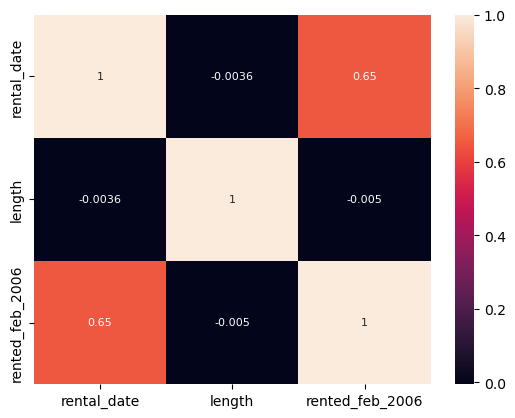

In [172]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":8})
plt.show()

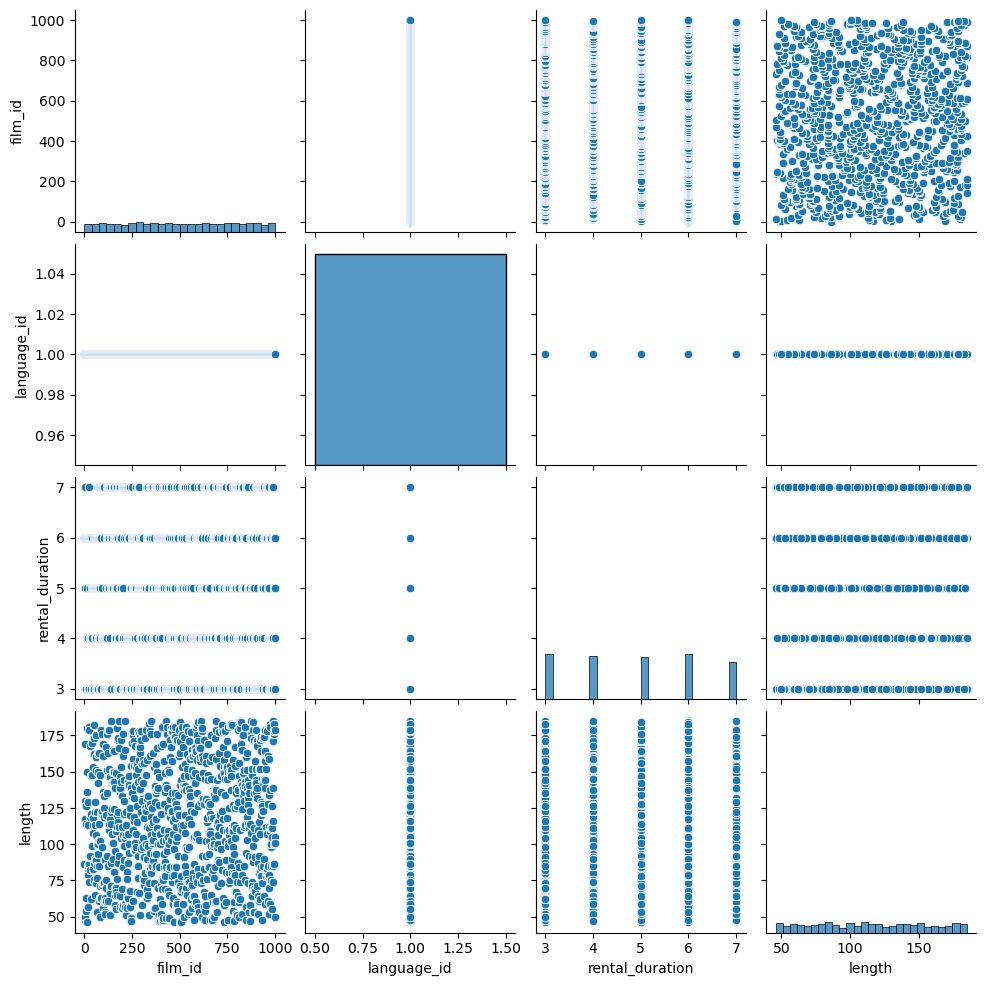

In [205]:
sns.pairplot(data)
plt.show()

In [173]:
X = data.select_dtypes(include = np.number)
X

,rental_date,length
0,732135,86
1,732160,86
2,732179,86
3,732096,86
4,732114,86
...,...,...
16039,732095,50
16040,732112,50
16041,732139,50
16042,732158,50


In [174]:
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)
x.columns = X.columns
x

,rental_date,length
0,1.0,0.000117
1,1.0,0.000117
2,1.0,0.000117
3,1.0,0.000117
4,1.0,0.000117
...,...,...
16039,1.0,0.000068
16040,1.0,0.000068
16041,1.0,0.000068
16042,1.0,0.000068


In [175]:
cat = data.select_dtypes(include = object)
cat

,film_id,language_id,rental_duration,rating,special_features
0,1,1,6,PG,"Deleted Scenes,Behind the Scenes"
1,1,1,6,PG,"Deleted Scenes,Behind the Scenes"
2,1,1,6,PG,"Deleted Scenes,Behind the Scenes"
3,1,1,6,PG,"Deleted Scenes,Behind the Scenes"
4,1,1,6,PG,"Deleted Scenes,Behind the Scenes"
...,...,...,...,...,...
16039,1000,1,3,NC-17,"Trailers,Commentaries,Behind the Scenes"
16040,1000,1,3,NC-17,"Trailers,Commentaries,Behind the Scenes"
16041,1000,1,3,NC-17,"Trailers,Commentaries,Behind the Scenes"
16042,1000,1,3,NC-17,"Trailers,Commentaries,Behind the Scenes"


In [176]:
categorical = pd.get_dummies(cat,columns=['rating','special_features','film_id','language_id','rental_duration'])
categorical

C:\Users\Utilizador\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",...,film_id_997,film_id_998,film_id_999,film_id_1000,language_id_1,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16039,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
16040,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
16041,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
16042,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0


In [177]:
X = np.concatenate((X,categorical),axis=1)
y = data['rented_feb_2006']

In [178]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4)

In [179]:
classification = LogisticRegression().fit(X_train,y_train)

In [206]:
model = LogisticRegression(class_weight='balanced')

In [207]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [208]:
predictions = classification.predict(X_test)
predictions

array([False, False, False, ..., False, False, False])

In [209]:
classification.score(X_test,y_test)

0.9881583047678405

In [210]:
y_test.value_counts()

False    6342
True       76
Name: rented_feb_2006, dtype: int64

In [211]:
pd.Series(predictions).value_counts()

False    6418
dtype: int64

In [212]:
confusion_matrix(y_test, predictions)

array([[6342,    0],
       [  76,    0]], dtype=int64)

In [213]:
model.score(X_test,y_test)

0.5137114365846058

In [197]:
data["next_month_rental"]=model.predict(X)

In [198]:
data

,film_id,language_id,rental_date,rental_duration,rating,length,special_features,rented_feb_2006,next_month_rental
0,1,1,732135,6,PG,86,"Deleted Scenes,Behind the Scenes",False,False
1,1,1,732160,6,PG,86,"Deleted Scenes,Behind the Scenes",False,False
2,1,1,732179,6,PG,86,"Deleted Scenes,Behind the Scenes",False,False
3,1,1,732096,6,PG,86,"Deleted Scenes,Behind the Scenes",False,False
4,1,1,732114,6,PG,86,"Deleted Scenes,Behind the Scenes",False,False
...,...,...,...,...,...,...,...,...,...
16039,1000,1,732095,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False,False
16040,1000,1,732112,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False,False
16041,1000,1,732139,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False,False
16042,1000,1,732158,3,NC-17,50,"Trailers,Commentaries,Behind the Scenes",False,False


In [199]:
data_next_month_rental = data[data['next_month_rental'] == True]

In [201]:
data_next_month_rental = data_next_month_rental[["film_id", "rented_feb_2006", "next_month_rental"]]

In [215]:
data_next_month_rental.head()

,film_id,rented_feb_2006,next_month_rental
42,4,False,True
43,4,False,True
44,4,False,True
45,4,False,True
46,4,False,True
